# Bayesian Optimization of Hyperparameter Tuning With Hyperopt

Common hyperparameter tuning techniques such as `Grid Search` and `Random Search` roam the full space of available parameter values in an isolated way without paying attention to past results. Tuning by means of these techniques can become a time-consuming challenge especially with large parameters spaces. The search space grows exponentially with the number of parameters tuned, whilst for each hyperparameter combination a model has to be trained, predictions have to be generated on the validation data, and the validation metric has to be calculated.

Hyperparameter tuning by means of Bayesian Optimization, can bring down the time spent to get to the optimal set of parameters — and bring better generalisation performance on the test set. It does this by taking into account information on the hyperparameter combinations it has seen thus far when choosing the hyperparameter set to evaluate next.

Hyperopt is a Python library that enables you to tune hyperparameters by means of this technique and harvest these potential efficiency gains.

## Generating the dummy dataset

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Generate dataset with 1000 samples, 100 features and 2 classes
def gen_dataset(n_samples=1000, n_features=100, n_classes=2, random_state=123):  
    X, y = datasets.make_classification(
        n_features=n_features,
        n_samples=n_samples,  
        n_informative=int(0.6 * n_features),    # the number of informative features
        n_redundant=int(0.1 * n_features),      # the number of redundant features
        n_classes=n_classes, 
        random_state=random_state)
    return (X, y)

X, y = gen_dataset(n_samples=1000, n_features=100, n_classes=2)

# Train / test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Setting up the GridSearch and Random Search parameter grid

In [8]:
from sklearn import pipeline
import lightgbm as lgb
import numpy as np
from hyperopt import hp
from hyperopt.pyll import scope

pipe = pipeline.Pipeline([
    ('clf', lgb.LGBMClassifier())
    ])

param_gridsearch = {
    'clf__learning_rate' : [0.01, 0.1, 1],
    'clf__max_depth' : [5, 10, 15],
    'clf__n_estimators' : [5, 20, 35], 
    'clf__num_leaves' : [5, 25, 50],
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree' : [0.6, 0.75, 1],
    'clf__reg_lambda': [0.01, 0.1, 1],
}

param_random = {
    'clf__learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 500, base=3)),
    'clf__max_depth': list(range(5, 15)),
    'clf__n_estimators': list(range(5, 35)),
    'clf__num_leaves': list(range(5, 50)),
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree': list(np.linspace(0.6, 1, 500)),
    'clf__reg_lambda': list(np.linspace(0, 1, 500)),
}

param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

## Grid Search & Random Search function

In [9]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import time
import pandas as pd

def search(pipeline, parameters, X_train, y_train, X_test, y_test, optimizer='grid_search', n_iter=None):
    
    start = time.time() 
    
    if optimizer == 'grid_search':
        grid_obj = GridSearchCV(estimator=pipeline,
                                param_grid=parameters,
                                cv=5,
                                refit=True,
                                return_train_score=False,
                                scoring = 'accuracy',
                               )
        grid_obj.fit(X_train, y_train,)
    
    elif optimizer == 'random_search':
        grid_obj = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=parameters,
                            cv=5,
                            n_iter=n_iter,
                            refit=True,
                            return_train_score=False,
                            scoring = 'accuracy',
                            random_state=1)
        grid_obj.fit(X_train, y_train,)
    
    else:
        print('enter search method')
        return

    estimator = grid_obj.best_estimator_
    cvs = cross_val_score(estimator, X_train, y_train, cv=5)
    results = pd.DataFrame(grid_obj.cv_results_)
    
    print("##### Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    print("Cross-validation Score: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ",results.shape[0])
    
    return results, estimator

## Grid Search & Random Search (75 iterations)

In [10]:
num_eval =75
#results_grid, estimator_grid = search(pipe, param_gridsearch, X_train, y_train, X_test, y_test, 'grid_search')
results_random, estimator_random = search(pipe, param_random, X_train, y_train, X_test, y_test, 'random_search', num_eval)

##### Results
Score best parameters:  0.8462500000000001
Best parameters:  {'clf__reg_lambda': 0.38476953907815625, 'clf__num_leaves': 38, 'clf__n_estimators': 31, 'clf__max_depth': 13, 'clf__learning_rate': 0.48682048838700065, 'clf__colsample_bytree': 0.6985971943887775, 'clf__boosting_type': 'dart'}
Cross-validation Score:  0.8462500000000001
Test Score:  0.835
Time elapsed:  12.481127500534058
Parameter combinations evaluated:  75


## Hyperopt function

In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = lgb.LGBMClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate = np.random.default_rng(2))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
    
    clf_best = lgb.LGBMClassifier(learning_rate=best_param_values[2],
                                  num_leaves=int(best_param_values[5]),
                                  max_depth=int(best_param_values[3]),
                                  n_estimators=int(best_param_values[4]),
                                  boosting_type=boosting_type,
                                  colsample_bytree=best_param_values[1],
                                  reg_lambda=best_param_values[6],
                                 )
                                  
    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

## Execute Hyperopt for 75 iterations

In [17]:
results_hyperopt = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval)

100%|██████████| 75/75 [00:14<00:00,  5.14trial/s, best loss: -0.8450000000000001]

##### Results
Score best parameters:  0.8450000000000001
Best parameters:  {'boosting_type': 0, 'colsample_by_tree': 0.9394247905705991, 'learning_rate': 0.4970676503305924, 'max_depth': 6.0, 'n_estimators': 30.0, 'num_leaves': 41.0, 'reg_lambda': 0.6922086173168545}
Test Score:  0.81
Time elapsed:  14.64952540397644
Parameter combinations evaluated:  75


## Plot top validation scores over time for GridSearch and Random Search

In [18]:
# Retrieve Hyperopt scores

hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
hyperopt_scores = np.maximum.accumulate(hyperopt_scores)

# Retrieve Random Search scores

random_scores = np.maximum.accumulate(results_random['mean_test_score'])

[None, None, None, None]

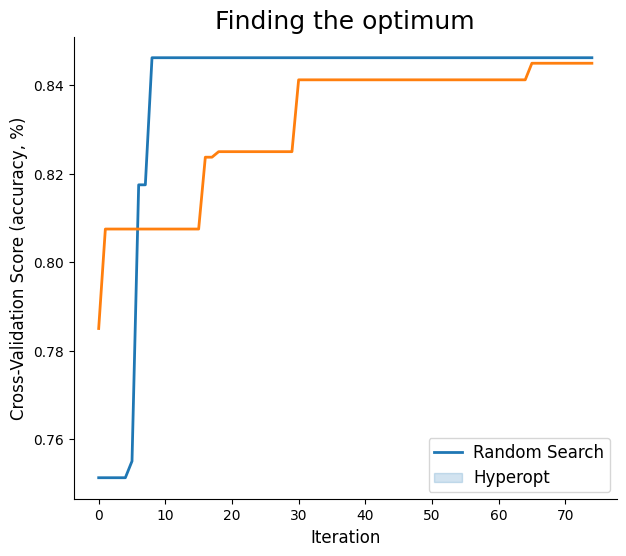

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot evaluation scores of each method over time

f, ax = plt.subplots(figsize=(7,6))
sns.set_palette("husl")
sns.despine()
ax = sns.lineplot(x=[x for x in range(num_eval)], y=random_scores, linewidth = 2)
ax = sns.lineplot(x=[x for x in range(num_eval)], y=hyperopt_scores, linewidth = 2)
plt.title("Finding the optimum", fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cross-Validation Score (accuracy, %)', fontsize=12)
plt.legend(loc='lower right', labels=['Random Search', 'Hyperopt'])
plt.setp(ax.get_legend().get_texts(), fontsize='12')

## References

- [Bayesian Optimization for quicker hyperparameter tuning](https://www.vantage-ai.com/en/blog/bayesian-optimization-for-quicker-hyperparameter-tuning)